In [1]:
import json
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.models import resnet50
from torchvision import models

import torch.nn as nn
import torch.optim as optim


In [2]:
torch.cuda.empty_cache()

In [3]:
class HatefulMemeDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        with open(json_file, "r") as f:
            self.data = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]["img"])
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label = self.data[index]["label"]

        return image, label


# Define the image transformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = HatefulMemeDataset(
    json_file="data/train.jsonl", img_dir="data/", transform=transform_train)
val_dataset = HatefulMemeDataset(
    json_file="data/dev_seen.jsonl", img_dir="data/", transform=transform_test)
test_dataset = HatefulMemeDataset(
    json_file="data/test_seen.jsonl", img_dir="data/", transform=transform_test)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=4)


In [27]:



# Define the ResNet-50 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move the model and loss function to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Train the model
num_epochs = 10
best_val_loss = float('inf')

tr_loss_arr = []
tr_acc_arr = []

val_loss_arr = []
val_acc_arr = []
for epoch in range(num_epochs):
    # Train loop
    model.train()
    train_loss = 0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images).squeeze()

        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += ((outputs >= 0.5).int() == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    tr_loss_arr.append(train_loss)
    tr_acc_arr.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()

            loss = criterion(outputs, labels.float())

            val_loss += loss.item() * images.size(0)
            val_correct += ((outputs >= 0.5).int() == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Print the epoch results
        print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)

        # Check if this is the best model so far based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "data/resnet18_hateful_memes.pth")


Epoch 1/10 -- Train Loss: 0.6528, Val Loss: 0.7945, Train Acc: 0.6459, Val Acc: 0.5180
Epoch 2/10 -- Train Loss: 0.5991, Val Loss: 0.9011, Train Acc: 0.6728, Val Acc: 0.5060
Epoch 3/10 -- Train Loss: 0.5656, Val Loss: 0.8666, Train Acc: 0.6945, Val Acc: 0.5060
Epoch 4/10 -- Train Loss: 0.5230, Val Loss: 0.9598, Train Acc: 0.7269, Val Acc: 0.4980
Epoch 5/10 -- Train Loss: 0.4765, Val Loss: 0.9887, Train Acc: 0.7556, Val Acc: 0.5200
Epoch 6/10 -- Train Loss: 0.4204, Val Loss: 1.1398, Train Acc: 0.7901, Val Acc: 0.4940
Epoch 7/10 -- Train Loss: 0.3803, Val Loss: 1.2135, Train Acc: 0.8165, Val Acc: 0.4960
Epoch 8/10 -- Train Loss: 0.3404, Val Loss: 1.1844, Train Acc: 0.8392, Val Acc: 0.4800
Epoch 9/10 -- Train Loss: 0.3045, Val Loss: 1.2824, Train Acc: 0.8599, Val Acc: 0.5140
Epoch 10/10 -- Train Loss: 0.2680, Val Loss: 1.2363, Train Acc: 0.8753, Val Acc: 0.5080


In [5]:
import torch
torch.save(model.state_dict(), 'data/modelq1.pt')

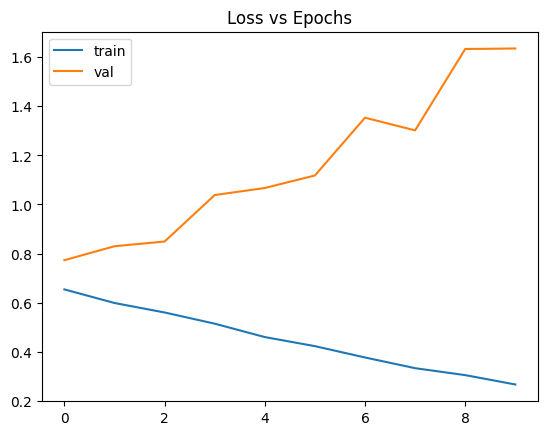

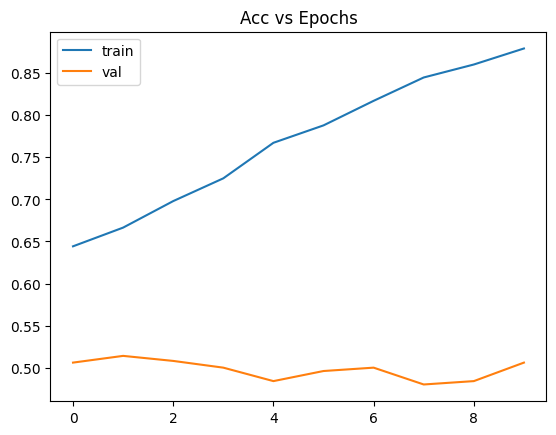

In [6]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_arr, label='train')
plt.plot(val_loss_arr, label='val')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

plt.plot(tr_acc_arr, label='train')
plt.plot(val_acc_arr, label='val')
plt.title('Acc vs Epochs')
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
true_labels = []
pred_labels = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)


    # Make predictions
    with torch.no_grad():
        outputs = model(images).squeeze()
        # print(outputs)
        # print(labels)
        predictions = np.where(outputs.cpu() > 0, 1, 0)

    # Add true labels and predicted labels to the lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predictions.tolist())

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1:{:.4f}'.format(f1))


Accuracy: 0.5260
Precision: 0.5252
Recall: 0.5232
F1:0.5151


In [32]:
from sklearn.metrics import classification_report

target_names = ['not_hateful', 'hateful']
report = classification_report(
    true_labels, pred_labels, target_names=target_names)

print('Class-wise Metrics:')
print(report)


Class-wise Metrics:
              precision    recall  f1-score   support

 not_hateful       0.53      0.66      0.59       510
     hateful       0.52      0.38      0.44       490

    accuracy                           0.53      1000
   macro avg       0.53      0.52      0.52      1000
weighted avg       0.53      0.53      0.52      1000

